## Feature Selection Demo Using `scikit-learn`
### PIMA Indians Diabetes Dataset

In this tutorial, I will use the *"PIMA Indians Diabetes"* dataset, where all
patients are females at least 21 years old of Pima Indian heritage.

The classification task is to predict whether an individual has diabetes from
the following features:

1. *Pregnancies* - Number of times pregnant
2. *Glucose* - Plasma glucose concentration at 2 hours in an oral glucose tolerance test
3. *Blood Pressure* - Diastolic blood pressure (mmHg)
4. *Skin Thickness* - Triceps skin fold thickness (mm)
5. *Insulin* - 2-hour serun insulin (mu U/ml)
6. *BMI* - Body mass index (weight in kg/(height in m)^2)
7. *Diabetes Pedigree Function*
8. *Age* (years)
9. *Outcome* - Class variable (0 or 1)

### Utility Functions & Imports

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from itertools import islice
from ToolBox import utils
import pandas as pd
import numpy as np
import sys
import os

def crossvalidate(classifier, X, y):
    # Perform four-fold cross-validation of the method
    scores = cross_val_score(classifier, X, y, cv=4, n_jobs=-1)
    print(f"--- 4-Fold Cross-Validation Accuracy: {scores.mean()*100:.1f}% (+/-{scores.std()*100:.1f})")

classifier = SVC(kernel='linear')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download Data File(s)

In [6]:
path = '/mnt/e/data/temp/pima-indians-diabetes.data'
utils.download('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', path)
print('--- First 5 lines of data file:')
utils.io_head(path, 5)

--- First 5 lines of data file:
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1


### Load Data

In [7]:
names = ['numpregnancies', 'glucose', 'diastolic', 'tricepskin', 'insulin', 
         'bmi', 'pedigree', 'age', 'hasdiabetes']
data = pd.read_csv(path, names=names)
print('--- First 5 rows of data:')
data.head(5)

--- First 5 rows of data:


,numpregnancies,glucose,diastolic,tricepskin,insulin,bmi,pedigree,age,hasdiabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
# Define data for ML
X = data.values[:, :-1]
y = data.values[:, -1]
names = names[:-1]

### Perform Classification Using All Features

In [9]:
crossvalidate(classifier, X, y)

--- 4-Fold Cross-Validation Accuracy: 76.3% (+/-1.7)


### Select Features Using Filters

For the list of available filters, see [scikit-learn.org](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)

In [10]:
from sklearn.feature_selection import SelectKBest, chi2

# Select top 3 features
selector = SelectKBest(chi2, k=3)
selector.fit(X, y)

print('--- Scores of the features')
sortedscores, sortednames = zip(*sorted(zip(selector.scores_, names), reverse=True))
for name, score in zip(sortednames, sortedscores):
    print(f"{name:<14}: {round(score, 1)}")

--- Scores of the features
insulin       : 2175.6
glucose       : 1411.9
age           : 181.3
bmi           : 127.7
numpregnancies: 111.5
tricepskin    : 53.1
diastolic     : 17.6
pedigree      : 5.4


In [11]:
print("--- Data with only the top k features")
subX = selector.transform(X)
subnames = selector.transform([names])[0]
pd.DataFrame(data=subX, columns=subnames).head(5)

--- Data with only the top k features


,glucose,insulin,age
0,148.0,0.0,50.0
1,85.0,0.0,31.0
2,183.0,0.0,32.0
3,89.0,94.0,21.0
4,137.0,168.0,33.0


In [12]:
# Perform classification with the selected features
crossvalidate(classifier, selector.transform(X), y)

--- 4-Fold Cross-Validation Accuracy: 73.7% (+/-3.3)


### Select Features Using Recursive Elimination

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# RFECV using the SVM classifier would take forever; let's use a faster method.
# quickclassifier = DecisionTreeClassifier()
quickclassifier = LogisticRegression(solver='liblinear')
selector = RFECV(quickclassifier, cv=4, scoring='accuracy')

selector.fit(X, y)

print(f'--- Selected Features ({selector.n_features_})')
[names[i] for i in range(len(names)) if selector.get_support()[i]]

--- Selected Features (5)


['numpregnancies', 'glucose', 'diastolic', 'bmi', 'pedigree']

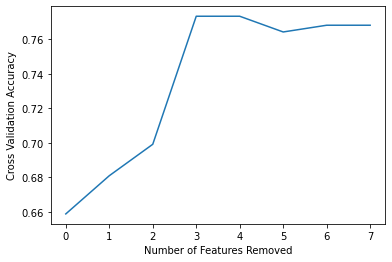

In [14]:
from pylab import plot, xlabel, ylabel
xlabel('Number of Features Removed')
ylabel('Cross Validation Accuracy')

scores = selector.cv_results_['mean_test_score']
plot(range(len(scores)), scores)

In [15]:
crossvalidate(classifier, selector.transform(X), y)

--- 4-Fold Cross-Validation Accuracy: 76.7% (+/-1.3)


### Sequential Forward Selection

In [17]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

quickclassifier = LogisticRegression(solver='liblinear')

# We'll use k_features to select all the way to the end, so I can manually
# visualize/decide how many features work best.
# You may want to avoid that if it takes to much time.
selector = SFS(quickclassifier, cv=4, scoring='accuracy',
               k_features=X.shape[1], forward=True)
selector.fit(X, y)

# Features shown here are NOT ordered by their performance.
print(f"--- Selected Features ({len(selector.k_feature_idx_)}):")
print(selector.k_feature_idx_)
[names[i] for i in selector.k_feature_idx_]

--- Selected Features (8):
(0, 1, 2, 3, 4, 5, 6, 7)


['numpregnancies',
 'glucose',
 'diastolic',
 'tricepskin',
 'insulin',
 'bmi',
 'pedigree',
 'age']

In [18]:
# Get each added attribute and the resulting score
selectnames = []
selectscores = []

for x in selector.get_metric_dict().values():
    newnames = set([names[i] for i in x['feature_idx']]).difference(selectnames)
    selectnames.append(','.join(newnames))
    names = names + list(newnames)
    selectscores.append(x['avg_score'])

In [22]:
selectscores

[0.75,
 0.7552083333333333,
 0.7643229166666667,
 0.765625,
 0.7734375,
 0.7786458333333334,
 0.77734375,
 0.7682291666666667]

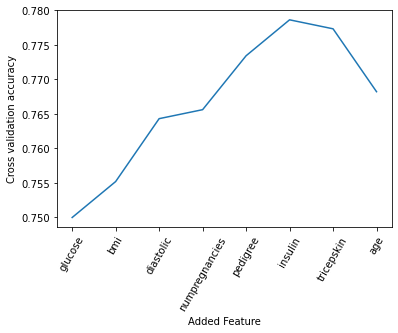

In [21]:
xlabel("Added Feature")
ylabel("Cross validation accuracy")
plot(range(1, len(selectscores)+1), selectscores)
import matplotlib.pyplot as plt
plt.xticks(range(1, len(selectscores)+1),selectnames,rotation=60);